In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from NCA import CA, totalistic

In [8]:
class SaveOutput:
    def __init__(self):        
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []
        
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        f = input.view(b, c, h*w) #bxcx(hxw)
        # torch.bmm(batch1, batch2, out=None)
        # batch1 : bxmxp, batch2 : bxpxn -> bxmxn
        G = torch.bmm(f, f.transpose(1, 2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
        return G.div_(h*w)
    
def gradient_normalizer(model):
    for parameter in model.parameters():
        if parameter.requires_grad == True:
            parameter.register_hook(lambda grad: grad / (grad.norm() + 1e-4))
    
    return model     

def norm_imgs(imgs):
    # normalize images (only) for vgg19
    mean = torch.tensor([0.485, 0.456, 0.406])[None,:,None,None].cuda()
    std = torch.tensor([0.229, 0.224, 0.225])[None,:,None, None].cuda()
    n_imgs = (imgs-mean) / std
    
    return n_imgs

# Test

In [9]:
RES=512 # resolution of grid
CHANNELS=12 # number of channels in grid
FILTERS=1 # number of filters per channel
HIDDEN=96 # number of hidden neurons
RADIUS=1 # radius if kernel

population = [CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN, RADIUS=RADIUS).cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1, RES=RES)
# embed = Embedder().cuda()

500


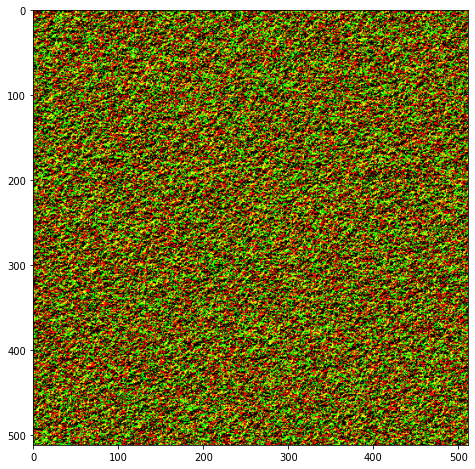

KeyboardInterrupt: 

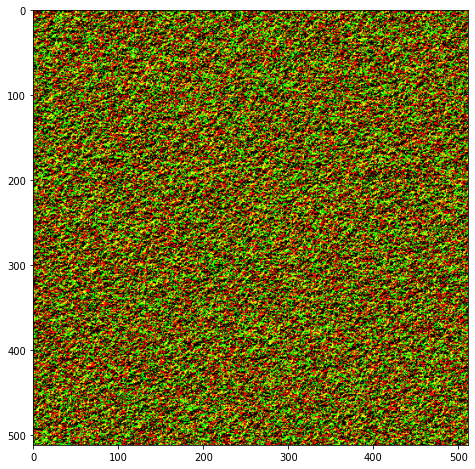

In [18]:
agent = 0
CA_run = population[agent]
# CA_run = ca_train
# CA_run.initGrid(BS=1, RES=RES)
RES = 512

# CENTER SEED
x = torch.cuda.FloatTensor(np.zeros((CHANNELS, RES, RES))).unsqueeze(0)
x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) > 0.9999).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) ).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.ones((CHANNELS, RES, RES))).unsqueeze(0)


state = torch.cuda.FloatTensor(x)

imgs = []

timeSteps = 1000
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)
with torch.no_grad():
    for i in range(timeSteps):
        nx = state.cpu().numpy()[0, 0:3, :, :].transpose(1, 2, 0)
        nx = np.clip(nx, 0, 1)
#         nx = rgba2rgb(nx)
#         nx = nx[:, :, 0]
        imgs.append(nx)

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

#         CA_run.forward()
        state = CA_run.forward_perception(state, dt=1)
    
#         signal_injection[:, noise_idx, :, :] = noise_amp * torch.randn(size=(signal_injection[:, noise_idx, :, :].shape))
#         signal_injection = signal_injection.to('cuda')
#         state = state + signal_injection
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [13]:
vgg19 = models.vgg19(pretrained=True)
vgg_readout = vgg19.features[:29].cuda()

save_features = SaveOutput()
save_content = SaveOutput()

feature_layers = [3, 6, 9, 12, 15, 20, 25]
content_layers = [0]
f_weights = [1] * len(feature_layers)
c_weights = [0] * len(content_layers)
multiplier = 1000000

f_weights = np.multiply(f_weights, multiplier)
c_weights = np.multiply(c_weights, multiplier)

loss_layers = feature_layers + content_layers
# layer_weights = torch.from_numpy(np.multiply(f_weights, multiplier)).float().cuda()

hook_handles = []
for i, layer in enumerate(vgg_readout.modules()):
    if i in feature_layers:
        handle = layer.register_forward_hook(save_features)
        hook_handles.append(handle)
    elif i in content_layers:
        handle = layer.register_forward_hook(save_content)
        hook_handles.append(handle)

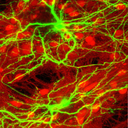

In [14]:
# content image
target_file = 'target/cover_vers1.jpg'
img = Image.open(target_file)
shape = np.array(img).shape
aspectratio = shape[0] / shape[1]

#show img thumbnail
img.resize((128, 128), Image.ANTIALIAS)

In [15]:
RES=128 # resolution of grid
CHANNELS=12 # number of channels in grid
FILTERS=6 # number of filters per channel
HIDDEN=96 # number of hidden neurons
RADIUS=1 # radius if kernel

ca_train = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN, RADIUS=RADIUS).cuda()
ca_train.initGrid(BS=1, RES=RES)
ca_train = gradient_normalizer(ca_train)

pool = ca_train.seed(n=1024, RES=RES)

1725


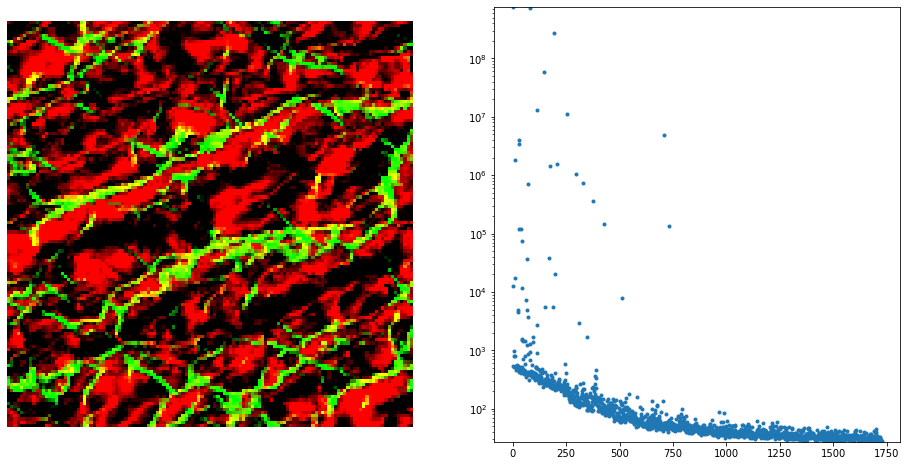

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

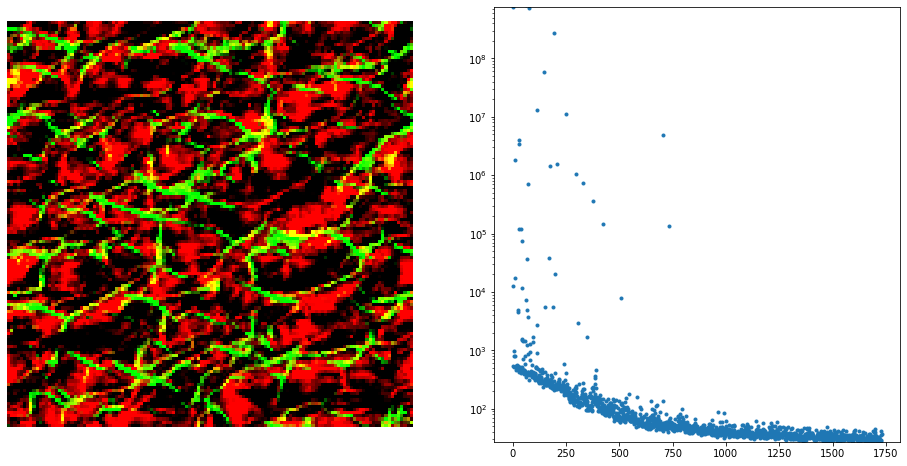

In [16]:
EPOCHS = 4000
BATCH_SIZE = 5

t_img = deepcopy(img)
t_img = t_img.resize((RES, RES), Image.ANTIALIAS)
#     t_img.thumbnail((RES, RES), Image.ANTIALIAS)
target = torch.FloatTensor(np.float32(t_img)[:, :, :3]/255.0).cuda().permute(2, 0, 1).unsqueeze(0)
target = norm_imgs(target)
with torch.no_grad():
    vgg_readout(target)
    target_gram = [GramMatrix()(o) for o in save_features.outputs]
    save_features.clear()
    save_content.clear()

imgs = []
loss_log = []
grad_log = []

state = ca_train.seed(n=BATCH_SIZE, RES=RES)

for epoch in range(EPOCHS):
    ca_train.optim.zero_grad()
    timeSteps = np.random.randint(32, 96)
    
    pool_idx = np.random.choice(len(pool), BATCH_SIZE, replace=False)
    state = pool[pool_idx].to(device='cuda')
    if epoch%2==0:
        state[:1] = ca_train.seed(n=1, RES=RES).to('cuda')  # some batches still have random seed
    
    for i in range(timeSteps):
        state = ca_train.forward_perception(state, dt=1)

#     out = norm_imgs(state[:, 0:3, :, :])
    out = state[:, 0:3, :, :]

#     loss = nn.MSELoss()(out, target)
#     loss_log.append(loss.item())
#     loss.backward() 
    
    vgg_readout(out)
    out_gram = [GramMatrix()(o) for o in save_features.outputs]
    save_features.clear()
    save_content.clear()

    loss = [nn.MSELoss()(out_gram[i], target_gram[i]) for i in range(len(out_gram))]
    loss = sum(loss)
    loss_log.append(loss.item())
    loss.backward()
    
#     grad_log.append(  [deepcopy(p.grad) for p in ca_train.parameters() if p.requires_grad==True] )
    pool[pool_idx] = state.detach().cpu()  # update sample pool 

    ca_train.optim.step()

    nx = state.detach().cpu().numpy()[0, 0:3, :, :].transpose(1, 2, 0)
    nx = np.clip(nx, 0, 1)
#     nx = rgba2rgb(nx)
    imgs.append(nx)

    if epoch%5 == 0:
        plt.clf()
        fig, axes = plt.subplots(1, 2, figsize=(16, 8));
        axes[0].imshow(nx)
        axes[0].axis('off')
        axes[1].plot(loss_log, '.')
        axes[1].set_ylim([np.min(loss_log), loss_log[0]])
        axes[1].set_yscale('log')
#         plt.gcf().set_size_inches((8,8))
        clear_output(wait=True)
        print(f'{epoch}')
        display(plt.gcf())
        time.sleep(0.01)


fname = time.strftime("%Y%m%d-%H%M%S")
vout = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for im in imgs:
    im = np.uint8(cv2.cvtColor(im, cv2.COLOR_RGB2BGR)*255.0)
    vout.write(im)
vout.release()

In [8]:
filters = [f.detach().cpu().numpy() for f in ca_train.rule.filters]
filters

[array([[-0.07241093, -2.1449986 , -0.1960846 ],
        [ 1.7096978 ,  0.37183076,  3.0033684 ],
        [ 1.0841559 ,  1.1149828 ,  1.7312547 ]], dtype=float32),
 array([[-0.45745084, -1.3843834 , -0.2352403 ],
        [-0.47513342, -0.53752106, -0.41113427],
        [-0.32778835,  1.3772554 ,  2.0343165 ]], dtype=float32)]

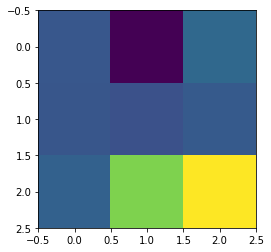

In [11]:
plt.imshow(filters[1])

In [22]:
[grad_log[i_e][i_p].sum() for i_e in range(len(grad_log)) for i_p in range(len(grad_log[i_e]))]

[tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(-10.8642, device='cuda:0'),
 tensor(-9.8574, device='cuda:0'),
 tensor(-7.2250, device='cuda:0'),
 tensor(-1.4765, device='cuda:0'),
 tensor(20.8318, device='cuda:0'),
 tensor(7.6219, device='cuda:0'),
 tensor(10.9065, device='cuda:0'),
 tensor(-16.4494, device='cuda:0'),
 tensor(-7.1802, device='cuda:0'),
 tensor(-10.8613, device='cuda:0'),
 tensor(11.7554, device='cuda:0'),
 tensor(7.2768, device='cuda:0'),
 tensor(7.2550, device='cuda:0'),
 tensor(10.7279, device='cuda:0'),
 tensor(7.1841, device='cuda:0'),
 tensor(8.4826, device='cuda:0'),
 tensor(9.1033, device='cuda:0'),
 tensor(6.9109, device='cuda:0'),
 tensor(7.8047, device='cuda:0'),
 tensor(7.3016, device='cuda:0'),
 tensor(6.2132, device='cuda:0'),
 tensor(7.9115, device='cuda:0'),
 tensor(-5.2832, device='cuda:0'),
 tensor(-4.5387, device='cuda:0'),
 tensor(-9.7952, device='cuda:0'),
 tensor(-4.3681, device='cuda:0'),
 tensor(-3.9655, device='cuda:0'),
 te